<span style="font-family: Arial; font-weight:bold;font-size:2.1em;color:#fff;">-----------------------------------
    
<span style="font-family: Arial; font-weight:bold;font-size:2.1em;color:#fa9200;">This NB Pulls Historical Stock Data from Yahoo Finance
    
<span style="font-family: Arial; font-weight:bold;font-size:2.1em;color:#fff;">-----------------------------------

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from datetime import date, datetime
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.formula.api as sm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import yfinance as yf
from scipy.signal import argrelextrema
from collections import defaultdict

# Grab Data for Ticker

In [120]:
ticker = "SSB"
start_date = date(2000,1,1)
my_ticker = yf.Ticker(ticker)
df = my_ticker.history(period="380d", interval = "1h")
df = df.reset_index()
df['date'] = df.Datetime.dt.tz_localize(None)
df.columns = [x.lower() for x in df.columns]
#df.drop(['datetime'], axis=1, inplace=True)
df

datetime       open       high        low      close  \
0    2022-09-02 09:30:00-04:00  78.400002  79.129997  78.320000  79.040001   
1    2022-09-02 10:30:00-04:00  79.060799  79.419998  79.060799  79.269997   
2    2022-09-02 11:30:00-04:00  79.339996  79.660004  79.070000  79.150002   
3    2022-09-02 12:30:00-04:00  79.010002  79.010002  77.900002  77.900002   
4    2022-09-02 13:30:00-04:00  77.875000  78.209999  77.769997  78.180000   
...                        ...        ...        ...        ...        ...   
2642 2024-03-07 14:30:00-05:00  83.959999  84.040001  83.764999  83.834999   
2643 2024-03-07 15:30:00-05:00  83.834999  84.010002  83.639999  83.730003   
2644 2024-03-08 09:30:00-05:00  85.169998  85.239998  84.050003  84.150002   
2645 2024-03-08 10:30:00-05:00  84.150002  84.620003  83.910004  83.910004   
2646 2024-03-08 11:30:00-05:00  84.029999  84.214996  84.010002  84.059998   

      volume  dividends  stock splits                date  
0      36932        0.0           0.0 2022-09-02 09:30:00  
1      18158        0.0           0.0 2022-09-02 10:30:00  
2      14705        0.0           0.0 2022-09-02 11:30:00  
3      21208        0.0           0.0 2022-09-02 12:30:00  
4      13726        0.0           0.0 2022-09-02 13:30:00  
...      ...        ...           ...                 ...  
2642   22915        0.0           0.0 2024-03-07 14:30:00  
2643   84009        0.0           0.0 2024-03-07 15:30:00  
2644   27339        0.0           0.0 2024-03-08 09:30:00  
2645   22456        0.0           0.0 2024-03-08 10:30:00  
2646    3222        0.0           0.0 2024-03-08 11:30:00  

[2647 rows x 9 columns]

# Plot Data

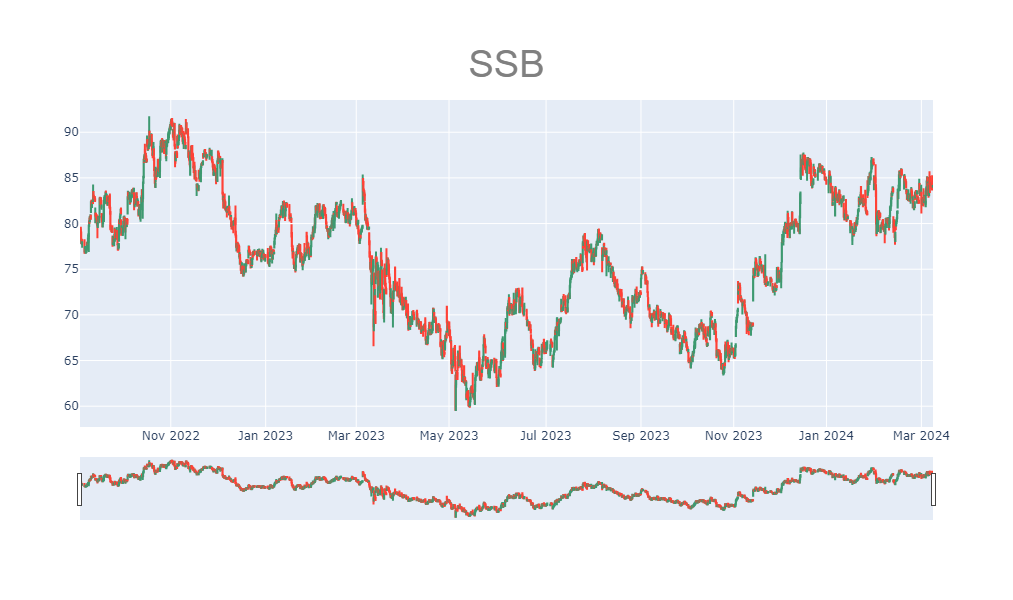

In [121]:
#df['date'] = df['date'].dt.strftime("%d-%m-%Y %H:%M:%S")
# build complete timepline from start date to end date
dt_all = pd.date_range(start=df['date'].iloc[0],end=df['date'].iloc[-1])
# retrieve the dates that ARE in the original datset
dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(df['date'])]
# define dates with missing values
dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]

fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38})
fig.show()

# Add SMAs

In [122]:
SMAs = [30,60,90]
for n in SMAs:
    df['SMA{}'.format(n)] = df['close'].rolling(window=n, center=False).mean()
df

datetime       open       high        low      close  \
0    2022-09-02 09:30:00-04:00  78.400002  79.129997  78.320000  79.040001   
1    2022-09-02 10:30:00-04:00  79.060799  79.419998  79.060799  79.269997   
2    2022-09-02 11:30:00-04:00  79.339996  79.660004  79.070000  79.150002   
3    2022-09-02 12:30:00-04:00  79.010002  79.010002  77.900002  77.900002   
4    2022-09-02 13:30:00-04:00  77.875000  78.209999  77.769997  78.180000   
...                        ...        ...        ...        ...        ...   
2642 2024-03-07 14:30:00-05:00  83.959999  84.040001  83.764999  83.834999   
2643 2024-03-07 15:30:00-05:00  83.834999  84.010002  83.639999  83.730003   
2644 2024-03-08 09:30:00-05:00  85.169998  85.239998  84.050003  84.150002   
2645 2024-03-08 10:30:00-05:00  84.150002  84.620003  83.910004  83.910004   
2646 2024-03-08 11:30:00-05:00  84.029999  84.214996  84.010002  84.059998   

      volume  dividends  stock splits                date      SMA30  \
0      36932        0.0           0.0 2022-09-02 09:30:00        NaN   
1      18158        0.0           0.0 2022-09-02 10:30:00        NaN   
2      14705        0.0           0.0 2022-09-02 11:30:00        NaN   
3      21208        0.0           0.0 2022-09-02 12:30:00        NaN   
4      13726        0.0           0.0 2022-09-02 13:30:00        NaN   
...      ...        ...           ...                 ...        ...   
2642   22915        0.0           0.0 2024-03-07 14:30:00  83.637833   
2643   84009        0.0           0.0 2024-03-07 15:30:00  83.675500   
2644   27339        0.0           0.0 2024-03-08 09:30:00  83.720500   
2645   22456        0.0           0.0 2024-03-08 10:30:00  83.774500   
2646    3222        0.0           0.0 2024-03-08 11:30:00  83.825833   

          SMA60      SMA90  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  
...         ...        ...  
2642  83.245583  83.294013  
2643  83.268083  83.277513  
2644  83.309333  83.267291  
2645  83.344666  83.262055  
2646  83.382750  83.258055  

[2647 rows x 12 columns]

# Plot with SMAs

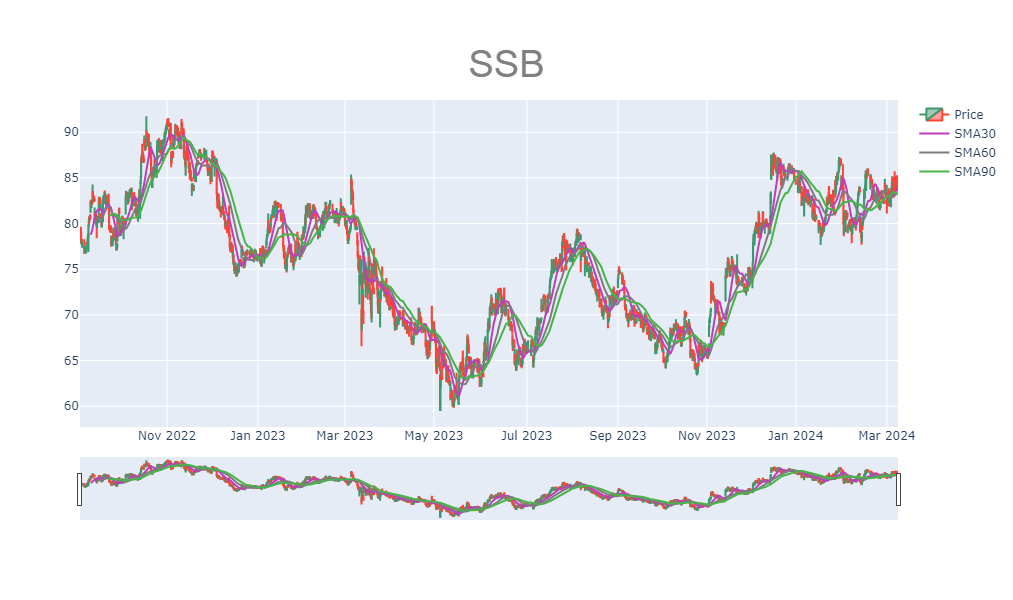

In [123]:
fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                name='Price')])
for n in SMAs:
    rgb = 'rgb({},{},{})'.format(250-n*2,n*2,250-n*2)
    fig.add_trace(go.Scatter(x=df['date'],
                y=df['SMA{}'.format(n)],
                mode='lines',
                name='SMA{}'.format(n),
                line=dict(color=rgb)))
    
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38})
fig.show()

# Add Local Min/Max

In [124]:
def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    #max_min.index.name = 'date'
    max_min = max_min.reset_index(drop=True)
    #max_min = max_min[~max_min.date.duplicated()]
    #p = prices.reset_index()   
    #max_min['day_num'] = p[p['timestamp'].isin(max_min.date)].index.values
    #max_min = max_min.set_index('day_num')['close']
    
    return max_min[['date','close']]

smoothing = 10
window = 15

minmax = get_max_min(df, smoothing, window)
minmax

date      close
0   2022-09-12 09:30:00  83.419998
1   2022-09-12 13:30:00  82.779999
2   2022-09-14 09:30:00  79.714996
3   2022-09-16 11:30:00  79.699997
4   2022-09-16 11:30:00  79.699997
..                  ...        ...
341 2024-03-01 15:30:00  82.290001
342 2024-03-01 15:30:00  82.290001
343 2024-03-05 13:30:00  85.065002
344 2024-03-05 13:30:00  85.065002
345 2024-03-05 13:30:00  85.065002

[346 rows x 2 columns]

# Plot with Min/Max

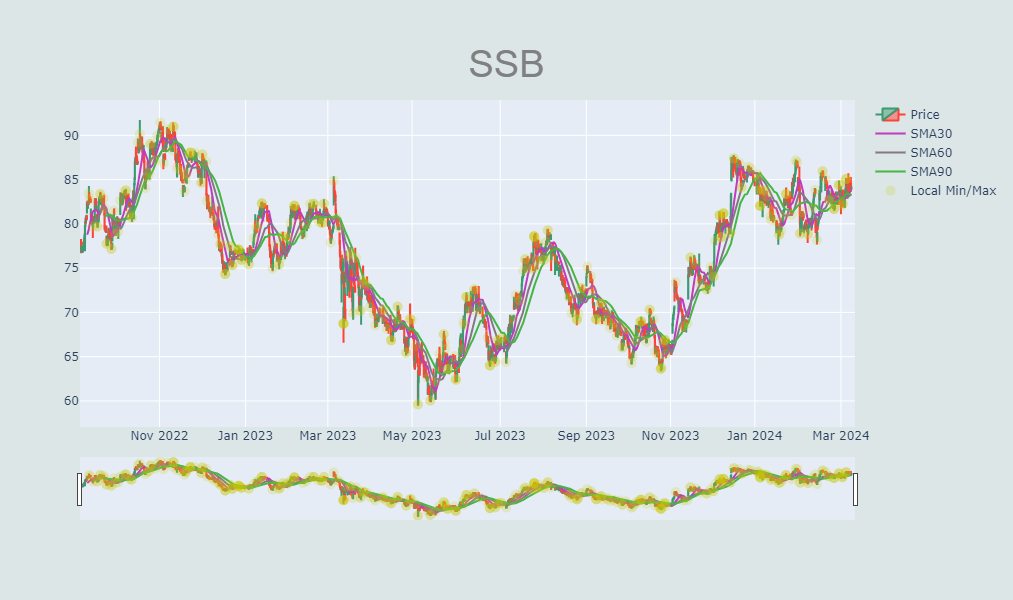

In [125]:
fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                name='Price')])
for n in SMAs:
    rgb = 'rgb({},{},{})'.format(250-n*2,n*2,250-n*2)
    fig.add_trace(go.Scatter(x=df['date'],
                y=df['SMA{}'.format(n)],
                mode='lines',
                name='SMA{}'.format(n),
                line=dict(color=rgb)))
fig.add_trace(go.Scatter(x=minmax['date'],
                y=minmax['close'],
                mode='markers',
                name='Local Min/Max',
                marker=dict(color='rgb(200,200,0)',
                            size=10,
                            opacity=0.2)
                        ))
    
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38},
                paper_bgcolor='rgb(220,230,230)'
                 )
fig.show()

# Add Head and Shoulders

In [136]:
def find_IHS(max_min):  
    patterns = defaultdict(list)
    
    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]['close']
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
               patterns['IHS'].append((window.index[0], window.index[-1]))
        
    final = pd.DataFrame()
    for x,y in patterns['IHS']:
        inv_min = list(max_min[max_min.index==x]['date'])[0]
        inv_max = list(max_min[max_min.index==y]['date'])[0]
        final = pd.concat([final,pd.DataFrame({'start_event':[inv_min],'end_event':[inv_max]})])
        
    return final

invhs = find_IHS(minmax).reset_index(drop=True)
invhs

start_event           end_event
0 2022-10-28 15:30:00 2022-11-09 14:30:00

# Plot w/ H&S

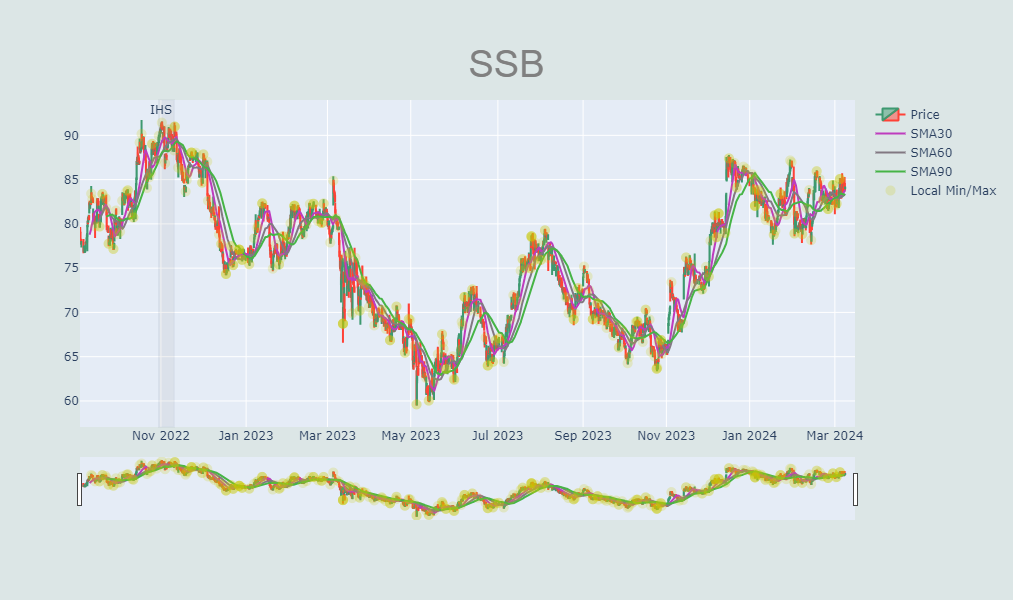

In [137]:
fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                name='Price')])
for n in SMAs:
    rgb = 'rgb({},{},{})'.format(250-n*2,n*2,250-n*2)
    fig.add_trace(go.Scatter(x=df['date'],
                y=df['SMA{}'.format(n)],
                mode='lines',
                name='SMA{}'.format(n),
                line=dict(color=rgb)))
fig.add_trace(go.Scatter(x=minmax['date'],
                y=minmax['close'],
                mode='markers',
                name='Local Min/Max',
                marker=dict(color='rgb(200,200,0)',
                            size=10,
                            opacity=0.2)
                        ))
# iterate through the shaded regions dataframe
for index, row in invhs.iterrows():
    
    # retrieve the dates
    start = row['start_event']
    end = row['end_event']

    # add shaded region
    fig.add_vrect(
            x0=start,
            x1=end,
            fillcolor="grey",
            opacity=0.1,
            line_width=1,
            annotation_text='IHS'
        )   
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38},
                paper_bgcolor='rgb(220,230,230)'
                 )
fig.show()

# Add Falling Wedge

In [143]:
def find_FW(max_min,buffer):  
    patterns = defaultdict(list)
    
    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]['close']
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
        
        m = (e-a)/4
        x1 = i-5
        b = a - x1*m
        def lower_line(x):
            y = m*x+b
            
            return y
            
        m = (d-b)/2
        x1 = i-3
        b = a - x1*m
        def upper_line(x):
            y = m*x+b
            
            return y
                
        # FW
        c1 = lower_line(c)
        e1 = lower_line(e)
        d1 = upper_line(d)
        if (a<b and c<a and a<d and d<b and e<d and e<c and
        #if (a<b and c<a and c<d and d<b and e<d and e<c and f<d and g<d and
            #abs(c1-c)<=np.mean([c1,c])*buffer and abs(e1-e)<=np.mean([e1,e])*buffer and
            abs(d1-d)<=np.mean([d1,d])*buffer):
               patterns['FW'].append((window.index[0], window.index[-1]))
        
    final = pd.DataFrame()
    for x,y in patterns['FW']:
        inv_min = list(max_min[max_min.index==x]['date'])[0]
        inv_max = list(max_min[max_min.index==y]['date'])[0]
        final = pd.concat([final,pd.DataFrame({'start_event':[inv_min],'end_event':[inv_max]})])
        
    return final

fw = find_FW(minmax,.03).reset_index(drop=True)
fw

Empty DataFrame
Columns: []
Index: []

# Plot FW

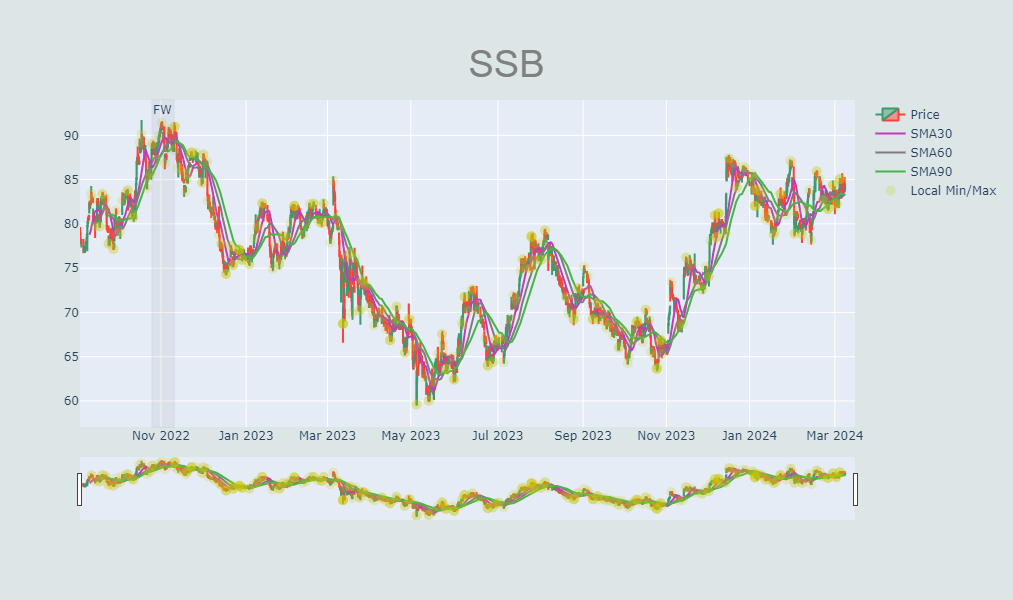

In [140]:
fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                name='Price')])
for n in SMAs:
    rgb = 'rgb({},{},{})'.format(250-n*2,n*2,250-n*2)
    fig.add_trace(go.Scatter(x=df['date'],
                y=df['SMA{}'.format(n)],
                mode='lines',
                name='SMA{}'.format(n),
                line=dict(color=rgb)))
fig.add_trace(go.Scatter(x=minmax['date'],
                y=minmax['close'],
                mode='markers',
                name='Local Min/Max',
                marker=dict(color='rgb(200,200,0)',
                            size=10,
                            opacity=0.2)
                        ))
# iterate through the shaded regions dataframe
"""
for index, row in invhs.iterrows():
    
    # retrieve the dates
    start = row['start_event']
    end = row['end_event']

    # add shaded region
    fig.add_vrect(
            x0=start,
            x1=end,
            fillcolor="grey",
            opacity=0.1,
            line_width=1,
            annotation_text='IHS'
        )   
"""
# iterate through the shaded regions dataframe
for index, row in fw.iterrows():
    
    # retrieve the dates
    start = row['start_event']
    end = row['end_event']

    # add shaded region
    fig.add_vrect(
            x0=start,
            x1=end,
            fillcolor="grey",
            opacity=0.1,
            line_width=1,
            annotation_text='FW'
        )  
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38},
                paper_bgcolor='rgb(220,230,230)'
                 )
fig.show()